In [2]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
import numpy as np
import os
import sys

# This works in Jupyter and interactive environments
notebook_dir = os.path.abspath("..")
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)


from credit_models import explain_customer_decision , modelValuation


In [6]:
rf_model = joblib.load(r"D:\Projects\CreditWorthinessModel\TestModels\my_random_forest_model1.pkl")

cb_model = CatBoostClassifier()
cb_model.load_model(r"D:\Projects\CreditWorthinessModel\TestModels\my_catboost_model1.cbm")

lgb_model = joblib.load(r"D:\Projects\CreditWorthinessModel\TestModels\my_lightgbm_model1.pkl")

# === Load and preprocess dataset ===
X = pd.read_csv(r"C:\Users\KrishnaWali\Downloads\german_credit_synthetic_balanced_cleaned.csv")
if "target" in X.columns:
    y = X.pop("target")


In [ ]:
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

In [16]:
expl_rf = shap.TreeExplainer(rf_model)
expl_cb = shap.TreeExplainer(cb_model)
expl_lgb = shap.TreeExplainer(lgb_model)


# === Compute SHAP values for all samples ===
shap_rf = expl_rf.shap_values(X_encoded, check_additivity=False)
shap_cb = expl_cb.shap_values(X_encoded, check_additivity=False)




In [8]:
X_lgb_compatible = X_encoded.copy()
for col in X.select_dtypes(include=["object"]).columns:
    X_lgb_compatible[col] = X_lgb_compatible[col].astype("category")

shap_lgb = expl_lgb.shap_values(X_lgb_compatible, check_additivity=False)


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [14]:
# For binary classification, focus on class 1 = "approved"
class_idx = 1

def global_feature_importance(shap_values, features_df):
    import numpy as np
    import pandas as pd

    # Handle LightGBM/CatBoost binary: list of [class0, class1]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_values = np.array(shap_values)

    # Handle RandomForest: (n_samples, n_features, 2)
    if shap_values.ndim == 3 and shap_values.shape[2] == 2:
        shap_values = shap_values[:, :, 1]  # focus on class 1

    if shap_values.ndim != 2:
        raise ValueError(f"Unsupported SHAP shape: {shap_values.shape}")

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    total = mean_abs_shap.sum()

    if len(mean_abs_shap) != features_df.shape[1]:
        raise ValueError("Mismatch between SHAP values and feature columns.")

    df = pd.DataFrame({
        "feature": features_df.columns,
        "mean_abs_shap": mean_abs_shap,
        "percent_contrib": 100 * mean_abs_shap / total
    }).sort_values("percent_contrib", ascending=False)

    return df


rf_factors = global_feature_importance(shap_rf, X_encoded)
cb_factors = global_feature_importance(shap_cb, X_encoded)
lgb_factors = global_feature_importance(shap_lgb, X_lgb_compatible)  # or X depending on how you fixed LGBM



C:\Users\KrishnaWali\AppData\Local\Temp\ipykernel_21788\2091566161.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="percent_contrib", y="feature", palette="viridis")
C:\Users\KrishnaWali\AppData\Local\Temp\ipykernel_21788\2091566161.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KrishnaWali\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


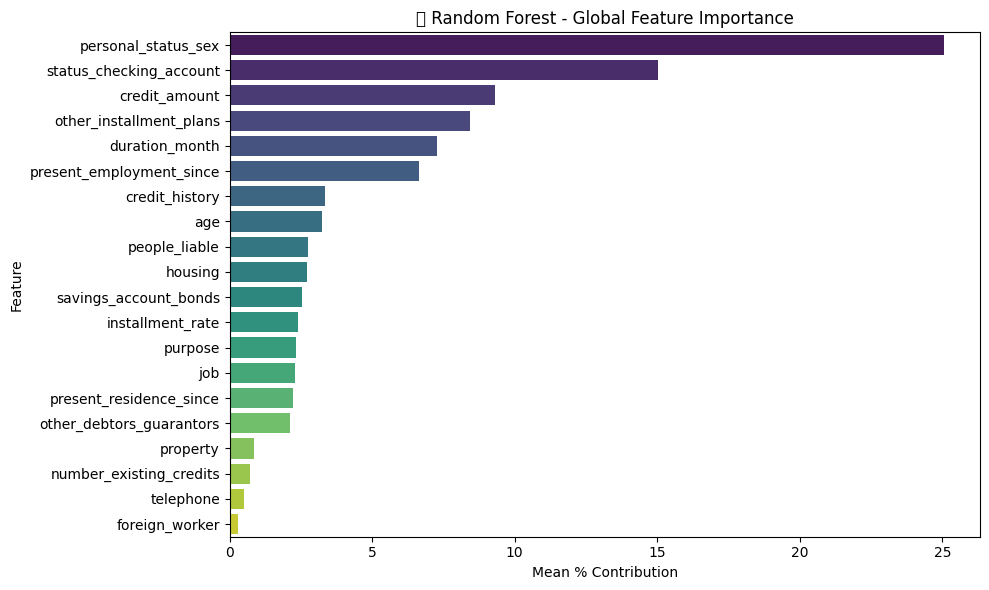

C:\Users\KrishnaWali\AppData\Local\Temp\ipykernel_21788\2091566161.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="percent_contrib", y="feature", palette="viridis")


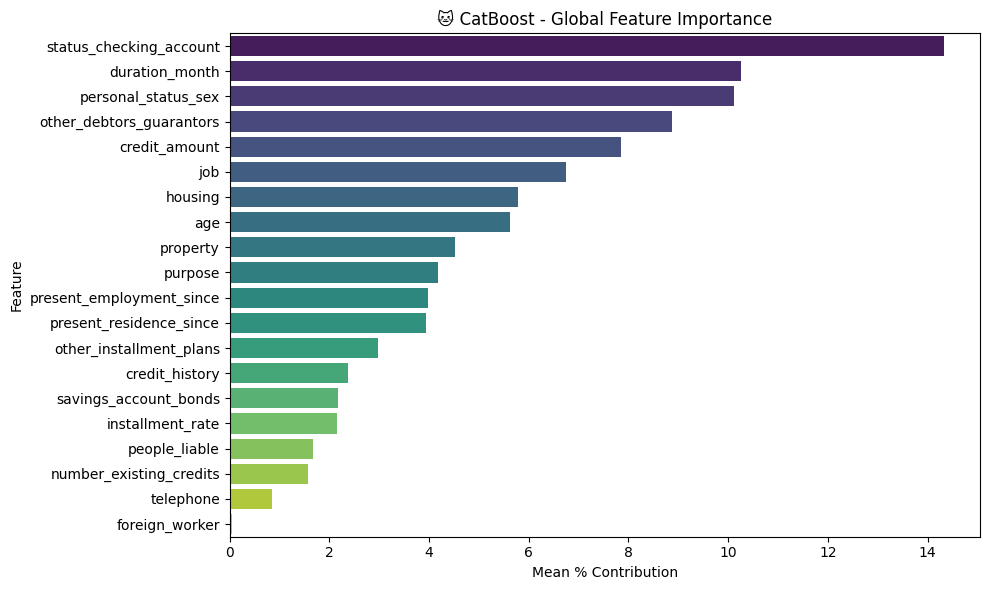

C:\Users\KrishnaWali\AppData\Local\Temp\ipykernel_21788\2091566161.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="percent_contrib", y="feature", palette="viridis")
C:\Users\KrishnaWali\AppData\Local\Temp\ipykernel_21788\2091566161.py:10: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KrishnaWali\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


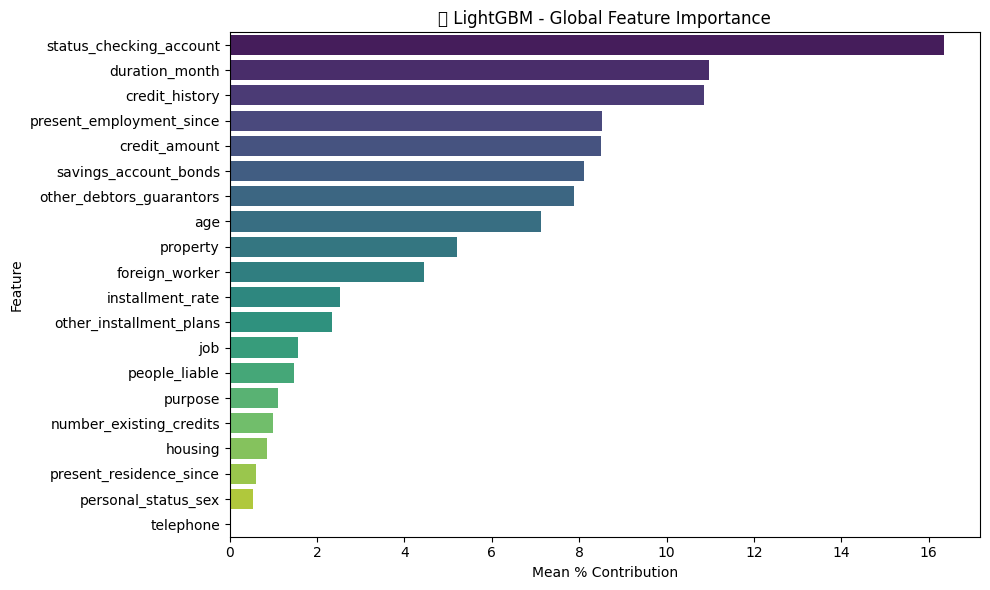

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importance(df, model_name):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="percent_contrib", y="feature", palette="viridis")
    plt.title(f"{model_name} - Global Feature Importance")
    plt.xlabel("Mean % Contribution")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# Plot all features for each model
plot_feature_importance(rf_factors, "🔍 Random Forest")
plot_feature_importance(cb_factors, "🐱 CatBoost")
plot_feature_importance(lgb_factors, "🌿 LightGBM")


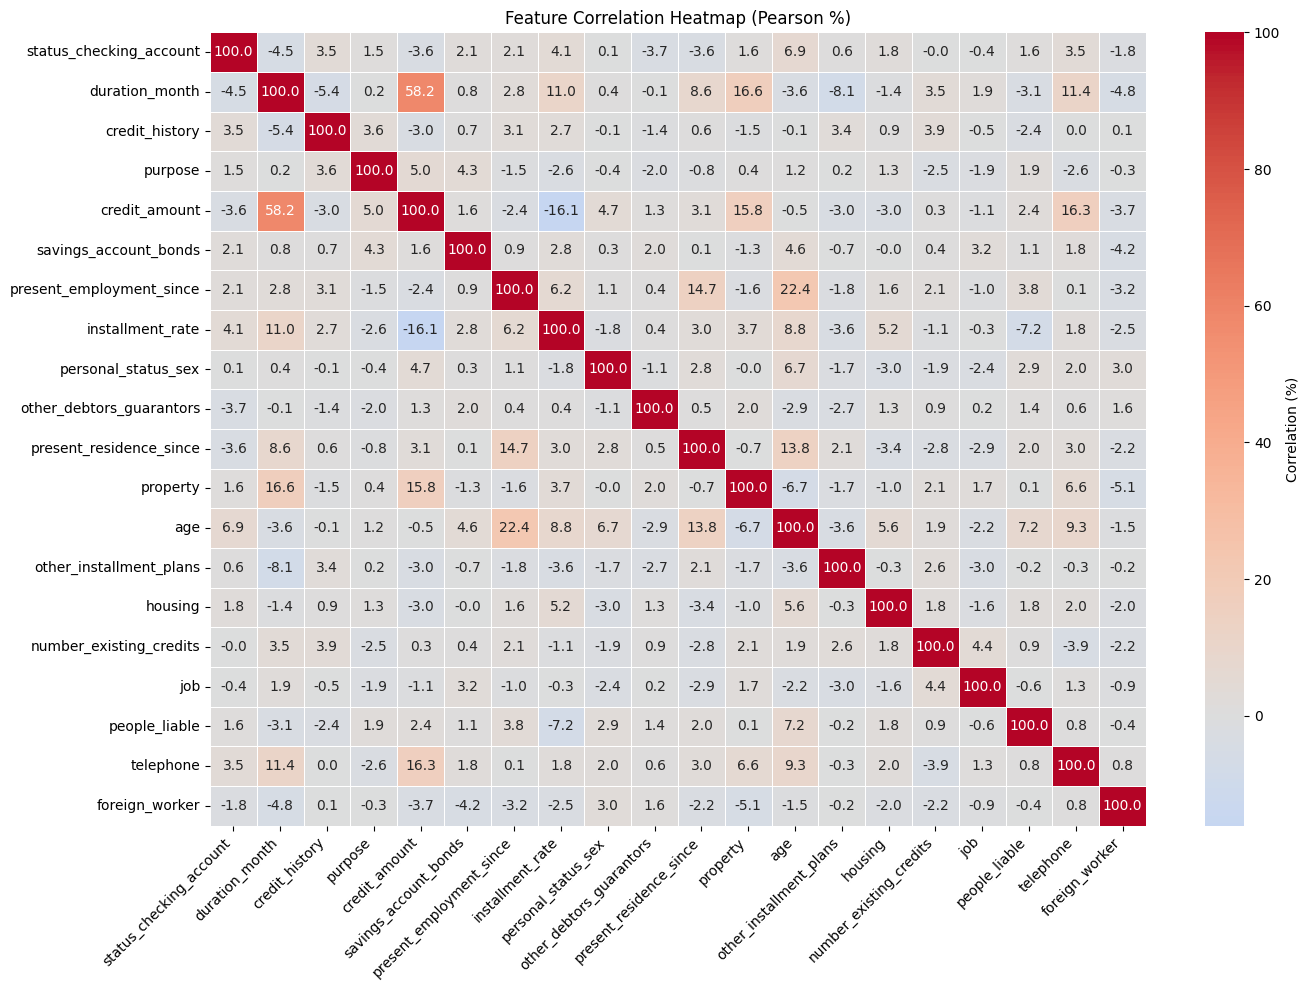

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix (using Pearson correlation)
corr_matrix = X_encoded.corr()

# Convert to percentages
corr_percent = corr_matrix * 100

# Create a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_percent, annot=True, fmt=".1f", cmap="coolwarm", center=0,
            cbar_kws={'label': 'Correlation (%)'}, linewidths=0.5)

plt.title("Feature Correlation Heatmap (Pearson %)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
customer_data = X_encoded.iloc[[1]]
explain_customer_decision(cb_model , customer_data , model_type= "catboost")

(0,
 np.float64(0.4004144620321004),
                      feature  feature_value  shap_value
 1             duration_month           32.0   -0.557823
 14                   housing            0.0   -0.269049
 11                  property            1.0   -0.250859
 9   other_debtors_guarantors            0.0   -0.248187
 16                       job            2.0   -0.205110)